# Part 1. Feature extraction
Today we want to finish extracting the first feature: mean acceleration in a number of different speed regions. After we derive the feature, we will try different classification algorithms and select the most effective one.

In [84]:
import DriverDataIO as io

In [85]:
trip = io.get_trip(1,1,'../drivers/')

In [86]:
%matplotlib inline

In [87]:
import DriverChallengeHelperFunctions as helpers

In [88]:
speed = helpers.get_speed(trip)

In [89]:
import DriverChallengeVisualization as vis

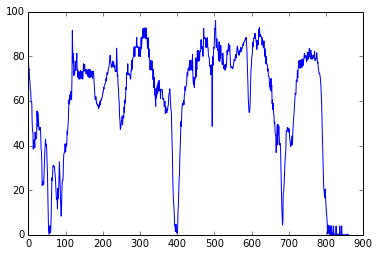

In [90]:
vis.plot_speed(speed)

In [91]:
def plot(items):
    """
    A short plotting utility function.
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()

    ax.plot([i[1] for i in items],[i[0] for i in items],'o-', color='b')
            
    plt.show()

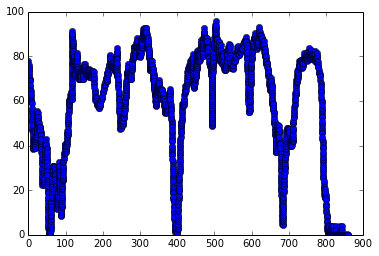

In [92]:
def interpolate_speed(_speed):
    """
    This function interpolates between speed points and adds a time point for every integer speed value.
    """
    import math
    interpolatedSpeed = []
    
    for t0, s0 in enumerate(_speed[:-1]):
        s1 = _speed[t0+1]
        
        
        interpolatedSpeed.append((s0,t0))
        
        left = min(s0, s1)
        right = max(s0,s1)
        #print "left {0} right {1}".format(left, right)
        for point in range(int(math.ceil(left)), int(math.floor(right))):
            t = (point - s0)/(s1-s0)+t0
            #print point, t
            interpolatedSpeed.append((point,t))
            
    return interpolatedSpeed

interpolated_speed = interpolate_speed(speed)
plot(interpolated_speed)

In [118]:
def get_acceleration(speed):
    """
    Computes acceleration for list of speed measurements.
    Acceleration is negative for breaking.
    @rtype list
    """
    acc = []
    for i in range(len(speed)-1):
        if speed[i+1][1] - speed[i][1] == 0.0:
            acc.append(0.0)
        else:
            acc.append((speed[i+1][0] - speed[i][0])/(speed[i+1][1] - speed[i][1]))
    return acc

In [122]:
def bin_speed_interval(_speed, _from, _to, _acceleration=True):    
    """
    Returns time values where the speed falls between the given _from and _to margins. 
    @param _acceleration: if true, then acceleration feature is computed, otherwise deceleration.
    @return time points and the speed value for points where speed lies in the requested interval.
    @rtype: list(tuple)
    """
    acc = get_acceleration(_speed)
    
    _speed = _speed[1:]
    
    intervals = []
    # start at index 2 due to shift of indices after deriving distance to acceleration
    for (sp, ac) in zip(_speed, acc):
        if (sp[0] >= _from and sp[0] <= _to):
            if (_acceleration and ac > 0) or (not _acceleration and ac < 0):
                intervals.append((sp[0],sp[1]))
        
    return intervals

In [127]:
tentothirty = bin_speed_interval(interpolated_speed, 10, 30, False)  # compute deceleration feature

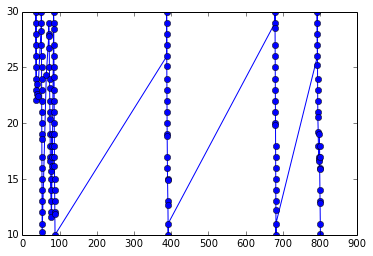

In [128]:
plot(tentothirty)

The plot above displays the speed distribution in the selected speed interval (10 to 30 kmph).

# Part 2. Computing features

We want to compute the following features:
  - acceleration, in the interval between:
      * 10 and 30 kmph,
      * 31 and 50 kmph,
      * 51 and 70 kmph;
  - deceleration, in the same intervals

In [165]:
def find_intervals(_interval, _acceleration=True):
    """
    Splits a list of points into connected intervals. 
    Points inside one interval are adjacent to each other. 
    Speed increases/decreases along the interval.
    Intervals are separated by at least one point where speed decreases/increases.
    """
    # allow only intervals with this minimum length to be used for feature extraction. 
    # Smaller intervals introduce high uncertainty nd numerical instability
    MIN_ALLOWED_INTERVAL_LENGTH = 2
    
    intervals = []
    pop = []
    for point in _interval:
        if len(pop) > 0 and ((_acceleration and point < pop[-1]) or (not _acceleration and point > pop[-1])):
            if len(pop) > MIN_ALLOWED_INTERVAL_LENGTH:  
                intervals.append(pop)
                
            pop = []
            
        pop.append(point)
        
    if len(pop) > MIN_ALLOWED_INTERVAL_LENGTH:
        intervals.append(pop)
    
    return intervals

In [182]:
import numpy as np

def compute_acceleration_feature(_intervals, feat=np.mean):
    """
    This function computes acceleration feature for a list of connected, 
    disjoint intervals with increasing speed.
    
    Mean acceleration across all intervals is chosen as the acceleration feature.
    
    @param feat: specify which type of statistic to use as the feature.
    @type feat: numpy.mean or numpy.std or numpy.median
    """
    prefeature = []
    for interval in _intervals:
        if abs(interval[-1][0] - interval[0][0]) < 0.1:
            continue
            
        value = (interval[-1][1] - interval[0][1])/(interval[-1][0] - interval[0][0])
        prefeature.append(abs(value))
        #print value
        
    return feat(prefeature)

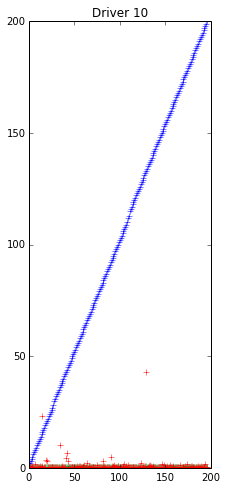

In [295]:
import math

import matplotlib.pyplot as plt
    
def compute_all_acc_features(driver):
    feature_array = []  # container for all acceleration features
    
    for i in range(1, 201):  # all trips
        _trip = io.get_trip(driver, i, '../drivers/')
        speed = helpers.get_speed(_trip)
        interpolated_speed = interpolate_speed(speed)
        feature_val = []
        #for (interval_begin, interval_end, acceleration) in [(10, 30, True), (10, 30, False)]:
        for (interval_begin, interval_end, acceleration, feat) in [(10, 30, True, np.median), (10, 30, True, np.std)]:
            interval = bin_speed_interval(interpolated_speed, interval_begin, interval_end, acceleration)
            contiguous_intervals = find_intervals(interval, acceleration)
            feature_val.append( compute_acceleration_feature(contiguous_intervals, feat=feat) )

        if all(not math.isnan(val) for val in feature_val):
            feature_array.append([i] + feature_val)

    features = np.array(feature_array)
    
    return features
    

driver = 10

drivers = [10,11,12,13]
plt.figure(figsize=(15,8))

for driver_index, driver in enumerate(drivers):
    features = compute_all_acc_features(driver)
    
    D = np.ones(len(features))*driver
    features = np.c_[ D, features]
    subplot = plt.subplot(1, len(drivers), driver_index)
    subplot.set_title('Driver %d' % driver)
    subplot.plot([f[1:] for f in features], '+')
    #subplot.set_ylim(0, 10.0)
    
    #print features
    break
    
    
#import matplotlib.pyplot as plt
#ax = plt.plot([f[1:] for f in features], '+')

# quick idea: 
# compute correlation between both features for each driver:
# http://stackoverflow.com/questions/11121762/in-python-how-can-i-calculate-correlation-and-statistical-significance-between

    #print features
    #print [f[1:2] for f in features]
    #print np.corrcoef([f[1] for f in features], [f[2] for f in features])
    #import scipy
    #print scipy.stats.pearsonr([f[1] for f in features], [f[2] for f in features])
    #print scipy.spatial.distance.mahalanobis([f[1] for f in features], [f[2] for f in features])

First clever thought:
Not all features are equally useful.

# Part 3. Machine learning
## Trying different algorithms
Next we want to filter out the outliers with scikit-learn.

In [152]:
import sklearn

First, lets try K-means algorithm.

In [266]:
#from sklearn.cluster import KMeans 
#filtered_features = [f for f in feature1030 if not math.isnan(f[1])]
##print filtered_features[13]
##print filtered_features
#data = numpy.array(filtered_features)
##print data
#n_samples, n_features = data.shape
#estimator = KMeans(init='k-means++', n_clusters=8, n_init=10)
#estimator.fit(data)
#estimator.labels_

Now, let's try something that works: [Elliptic Envelope](http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html)

In [306]:
def fit_elliptic_envelope(_features, outliers_fraction = 0.02, plot=False):
    from sklearn import covariance

    clf = covariance.EllipticEnvelope(contamination=.1)

    #print features[:,2], features[:,3]
    features_only = np.c_[_features[:,2], _features[:,3]]
    #print features_only

    clf.fit(features_only)  
    y_pred = clf.decision_function(features_only).ravel()

    # define a threshold for probabilities
    from scipy import stats
    threshold = stats.scoreatpercentile(y_pred, 100 * outliers_fraction)
    y_pred = y_pred > threshold
    #print y_pred

    # plot results
    if plot:
        plt.scatter([i[0] for i in features_only], [i[1] for i in features_only], c=y_pred, cmap='cool')
    
    return np.c_[_features[:,0], _features[:,1], y_pred]

res = fit_elliptic_envelope(features)
print res

[[  2.44000000e+03   1.00000000e+00   1.00000000e+00]
 [  2.44000000e+03   2.00000000e+00   1.00000000e+00]
 [  2.44000000e+03   3.00000000e+00   1.00000000e+00]
 [  2.44000000e+03   4.00000000e+00   1.00000000e+00]
 [  2.44000000e+03   5.00000000e+00   1.00000000e+00]
 [  2.44000000e+03   6.00000000e+00   1.00000000e+00]
 [  2.44000000e+03   7.00000000e+00   1.00000000e+00]
 [  2.44000000e+03   8.00000000e+00   1.00000000e+00]
 [  2.44000000e+03   9.00000000e+00   1.00000000e+00]
 [  2.44000000e+03   1.00000000e+01   1.00000000e+00]
 [  2.44000000e+03   1.10000000e+01   1.00000000e+00]
 [  2.44000000e+03   1.20000000e+01   1.00000000e+00]
 [  2.44000000e+03   1.30000000e+01   1.00000000e+00]
 [  2.44000000e+03   1.40000000e+01   1.00000000e+00]
 [  2.44000000e+03   1.50000000e+01   1.00000000e+00]
 [  2.44000000e+03   1.60000000e+01   1.00000000e+00]
 [  2.44000000e+03   1.80000000e+01   1.00000000e+00]
 [  2.44000000e+03   1.90000000e+01   1.00000000e+00]
 [  2.44000000e+03   2.00000

Idea: try to fit the model for each feature separately, then compute the sum of probabilities of each point being an outlier.

# First submission
Next we shall create the first submission file.

In [296]:
def list_all_drivers():
    import os

    drivers = []

    for f in os.listdir('../drivers'):
        try:
            int(f)
            drivers.append(f)
        except ValueError:
            pass
        
    return drivers

def list_all_drives():
    drives = {}
    for driver in list_all_drivers():
    #    cur_drives = []
    #    for f in os.listdir('../drivers/%s' % driver):
    #        try:
    #        #    int(f)
    #            cur_drives.append(f)
    #        except ValueError:
    #            pass
    #    
        drives[driver] = 200
        
    return drives

344 200
345 200
346 200
347 200
341 200
342 200
343 200
348 200
3530 200
2919 200
2318 200
2319 200
2316 200
2317 200
2314 200
2315 200
2312 200
2310 200
2311 200
298 200
299 200
297 200
294 200
295 200
292 200
290 200
291 200
270 200
271 200
272 200
273 200
275 200
277 200
278 200
279 200
3211 200
2268 200
2269 200
2262 200
2263 200
2260 200
2261 200
2266 200
2267 200
2264 200
2265 200
2442 200
2443 200
2440 200
2441 200


KeyboardInterrupt: 

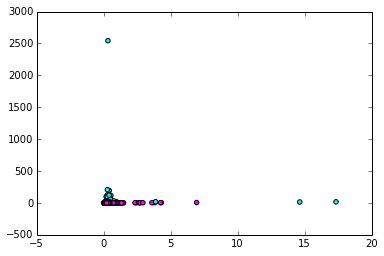

In [305]:
res = []

for driver, num_drives in list_all_drives().iteritems():
    print driver, num_drives
    features = compute_all_acc_features(int(driver))    
    D = np.ones(len(features))*int(driver)
    features = np.c_[ D, features]
    
    res.extend( fit_elliptic_envelope(features) )

In [293]:
from Submission import create_submission

create_submission('../submissions/1.csv', res)

submission file written to ../submissions/1.csv
